In [ ]:
#|default_exp triangle_condition_curvature
# Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
from tqdm.auto import tqdm, trange
# Configure environment


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import autometric
import torch

from autometric.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Triangle Condition Curvature
> Evaluating geodesics using Alexandrov geometry

In [ ]:
show_doc(compute_triangle_curvatures)

---

### compute_triangle_curvatures

>      compute_triangle_curvatures (X:numpy.ndarray, D:numpy.ndarray,
>                                   geodesic_fn, num_triangles=100,
>                                   min_edge_length=1, max_edge_length=1.5)

Compures the Alexandrov curvature of sampled triangles. Returns ks, centroids; ks is a list of Alexandrov curvatures, and centroids is a list of the centroids of each triangle, which can be used to compare to ground truth curvatures.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| X | ndarray |  | pointcloud |
| D | ndarray |  | distances on pointcloud; preferable manifold distances (PHATE). Used for creating triangles. Doesn't need to come from the geodesics. |
| geodesic_fn |  |  | function that takes start_points, end_points and ts and returns (a list of geodesics, length of each geodesic) |
| num_triangles | int | 100 |  |
| min_edge_length | int | 1 | Must tune to each dataset. Defaults for torus. |
| max_edge_length | float | 1.5 |  |

Note that the geodesic function should train on the points before spitting out the geodesic.

See Tests/Torus for usage details.

# Implementation

We create a test point cloud (the torus), and 
1. Convert it into an o3d format, compute nearest neighbor distances.
2. Downsample to the appropriate size
3. Create a mesh with the appropriate number of triangles

In [ ]:
from autometric.datasets import Torus, SwissRoll

INFO: Using pytorch backend


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
torus = Torus(num_points = 3000)
X_torus = torus.X.numpy()
D_euc = pairwise_distances(X_torus, X_torus)
swiss_roll = SwissRoll(num_points = 10000)
D_swiss_roll = pairwise_distances(swiss_roll.X, swiss_roll.X)

In [ ]:
#|export
import numpy as np
def create_triangles_from_pointcloud(
    X:np.ndarray, 
    D:np.ndarray, # manifold distance matrix of X; shape (num_points, num_points).
    min_dist:float=0.1, # triangle edges must length greater than this
    max_dist:float=0.3,
    num_triangles=100,
    hypotenuse_less_than = 1.7, # the hypotenuse times this should be less than the sum of the other two sides
    ):
    triangles = []
    while len(triangles) < num_triangles:
        candidate_idxs = np.random.choice(X.shape[0], num_triangles, replace=False)
        for a in candidate_idxs:
            # find idxs of points with distances greater than min_dist from a
            idxs = np.where((D[a,:] > min_dist) & (D[a,:] < max_dist))[0]
            if len(idxs) == 0:
                continue
            # sort by distance from a
            idxs = idxs[np.argsort(D[a,idxs])]
            for b in idxs:
                # find idxs of points with distances greater than min_dist from b and a
                idxs = np.where((D[b,:] > min_dist) & (D[b,:] < max_dist) & (D[a,:] > min_dist) & (D[a,:] < max_dist) & ((D[a, :] + D[b,:]) > hypotenuse_less_than*D[a,b]))[0]
                if len(idxs) == 0:
                    continue
                else:
                    # sort by distance from a and b
                    idxs = idxs[np.argsort(D[b,idxs] + D[a,idxs])]
                    if isinstance(idxs, int): idxs = [idxs]
                    for c in idxs:
                        if (D[a, b] + D[b,c]) > hypotenuse_less_than*D[a,c] and (D[a, c] + D[a, b]) > hypotenuse_less_than*D[b,c]:
                            triangles.append([a, b, c])
                            break
                    break
    return np.array(triangles)[:num_triangles]

In [ ]:
triangles = create_triangles_from_pointcloud(X_torus, D_euc, min_dist = 1, max_dist=1.5, num_triangles=14)

In [ ]:
swiss_roll_triangles = create_triangles_from_pointcloud(swiss_roll.X, D_swiss_roll, min_dist = 10, max_dist = 12, num_triangles = 100, hypotenuse_less_than=1.9)

In [ ]:
#|export
def get_geodesics_from_triangle(geodesic_fn, X, triangle_idxs, t = np.linspace(0,1,100)):
    start_idxs = [triangle_idxs[0], triangle_idxs[0], triangle_idxs[1]]
    end_idxs = [triangle_idxs[1], triangle_idxs[2], triangle_idxs[2]]
    start_points = torch.as_tensor(X[start_idxs])
    end_points = torch.as_tensor(X[end_idxs])
    points, lengths = geodesic_fn(start_points, end_points, t)
    return points, lengths

In [ ]:
#|export
from autometric.utils import plot_3d_with_geodesics
def plot_triangle_in_3d(X, triangle_idxs, geodesic_fn):
    gs, lengths = get_geodesics_from_triangle(geodesic_fn, X, triangle_idxs)
    plot_3d_with_geodesics(X, gs, title=f"Triangle {triangle_idxs}")
    

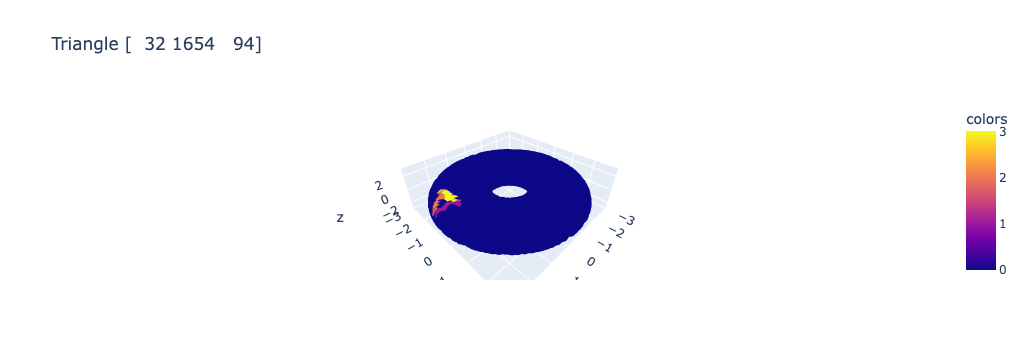

In [ ]:
plot_triangle_in_3d(X_torus, triangles[2], geodesic_fn=torus.geodesics)

It's notable that even on this 3000 point noiseless torus, using Dijkstra for shortest paths, it's not doing very well. The triangles generated with Dijkstra Geodesics are very noisy. Occasional bits of sparsity are trending it away from the true line, creating fat triangles where they should be skinny, and vice versa.

This raises the possibility that our method can possibly outperform Dijkstra, even in noiseless, fairly densely sampled data.

In [ ]:
#|export
def euclidean_section_length(
    a, # length from b' to c'
    b, # length from c' to a'
    c, # length from a' to b'
    c1 # length from b' to midpoint
    ):
    # computes the euclidean length of an edge running from vertex c' to a midpoint c1 on edge opposite
    inner = c1**2 + a**2 + c1*((b**2 - a**2 - c**2)/c)
    return inner**0.5
    # computes the euclidean length of an edge running from vertex c' to a midpoint on the edge opposite, c1

def alexandrov_curvature_of_triangle(X, triangle_idxs, geodesic_fn, return_extras = False):
    gs, lengths = get_geodesics_from_triangle(
        geodesic_fn, X, triangle_idxs
    )
    # three lengths are a, b, c. 
    a = lengths[0]
    b = lengths[1]
    c = lengths[2]
    # choose midpoint in third geodesic
    midpoint = gs[2][len(gs[2])//2]
    (c1_geodesic, d_geodesic), (c1, d) = geodesic_fn(X[[triangle_idxs[1], triangle_idxs[0]]], np.vstack([midpoint, midpoint]), np.linspace(0,1,100))
    d_euclidean = euclidean_section_length(a, b, c, c1)
    k = d - d_euclidean
    if return_extras:
        return k, gs, c1_geodesic, d_geodesic
    else:
        return k

In [ ]:
k, gs, c1_geodesic, d_geodesic = alexandrov_curvature_of_triangle(X_torus, triangles[0], torus.geodesics, return_extras = True)

In [ ]:
k

tensor(0.0128, dtype=torch.float64)

A sanity check that we are getting the correct lengths in the triangle

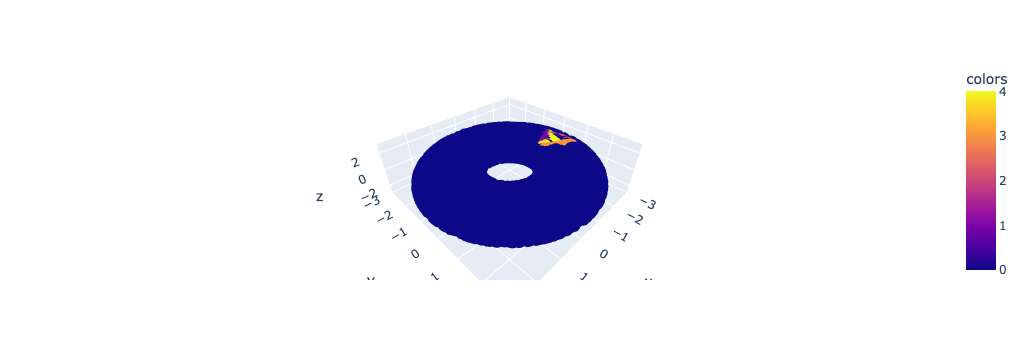

In [ ]:
plot_3d_with_geodesics(X_torus, gs, torch.vstack([c1_geodesic, d_geodesic]))

Another sanity check that this measure returns zero on the (flat) swiss roll.

In [ ]:
k, gs, c1_geodesic, d_geodesic = alexandrov_curvature_of_triangle(swiss_roll.X.numpy(), swiss_roll_triangles[23], swiss_roll.geodesics, return_extras = True)

/home/piriac/Pumberton/Workshop/23-Geometric-AE/dmae/src/autometric/src/autometric/datasets.py:216: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
k

tensor(-0.0002, dtype=torch.float64)

Indeed, all of the well-behaved triangles have near-zero curvature. The method is working.

In [ ]:
#|export
def compute_triangle_curvatures(X:np.ndarray, # pointcloud
                                D:np.ndarray, # distances on pointcloud; preferable manifold distances (PHATE). Used for creating triangles. Doesn't need to come from the geodesics.
                                geodesic_fn, # function that takes start_points, end_points and ts and returns (a list of geodesics, length of each geodesic)
                                num_triangles = 100, 
                                min_edge_length = 1,  # Must tune to each dataset. Defaults for torus.
                                max_edge_length = 1.5,
                                ):
    """Compures the Alexandrov curvature of sampled triangles. Returns ks, centroids; ks is a list of Alexandrov curvatures, and centroids is a list of the centroids of each triangle, which can be used to compare to ground truth curvatures."""
    triangles = create_triangles_from_pointcloud(X, D, min_edge_length, max_edge_length, num_triangles)
    ks = []
    centroids = []
    for t in tqdm(triangles):
        k, gs, c1_geodesic, d_geodesic = alexandrov_curvature_of_triangle(X, t, geodesic_fn, return_extras = True)
        ks.append(float(k))
        centroids.append(d_geodesic[len(d_geodesic)//2])
    return np.array(ks), np.vstack(centroids)

Using the centroids this returns, we can find the ground truth curvatures corresponding to each triangle.

In [ ]:
#|export
from sklearn.metrics import pairwise_distances
def get_ground_truth_curvature_at_triangle_centroids(
    X, # pointcloud n x d
    ks, # ground truth curvatures per point, shape n
    centroids, # centroids, m x d
):
    """
    Returns the ground truth curvature at the point closest to each centroid.
    """
    centroid_to_X_distances = pairwise_distances(centroids, X)
    closest_idx_to_centroid = np.argmin(centroid_to_X_distances, axis=1)
    curvatures_at_centroids = ks[closest_idx_to_centroid]
    return curvatures_at_centroids.detach().numpy()
    

# Tests

In [ ]:
from autometric.datasets import Torus, Sphere

## With the torus + sign prediction on centroids

In [ ]:
torus = Torus(num_points = 3000)
X_torus = torus.X.numpy()
D_euc = pairwise_distances(X_torus, X_torus) # preferably use PHATE distances here

In [ ]:
ks, centroids = compute_triangle_curvatures(X_torus, D_euc, 
                                       torus.geodesics, # a geodesic function
                                       num_triangles = 10, min_edge_length = 1, max_edge_length = 1.5) # pretuned edge lengths

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
ks

array([-0.03235253, -0.20050333, -0.07199789,  0.02184977,  0.06006044,
       -0.10150639, -0.09628273, -0.24442615,  0.12555403, -0.0251461 ])

This function gets the ground truth curvatures for each triangle centroid.

In [ ]:
true_ks = get_ground_truth_curvature_at_triangle_centroids(X_torus, torus.ks, centroids)

In [ ]:
true_ks

array([-0.00503661, -0.73041797, -0.23105158, -1.4138694 ,  0.66534096,
        0.10064843,  0.5876634 , -1.0850735 ,  0.5450748 , -0.3395804 ],
      dtype=float32)

We can then compute whatever stats we like with `ks` and `true_ks`. Note that the triangle curvature uses a completely different scale than Gaussian curvature, so predicting sign is likely our best bet.

In [ ]:
sum((np.sign(ks) == np.sign(true_ks)).astype(int))/len(ks)

0.7

## With Sphere, showing how to tune the triangle sizes.

In [ ]:
sphere = Sphere(num_points = 10000)
X_sphere = sphere.X
D_euc_sphere = pairwise_distances(X_sphere, X_sphere)

/tmp/ipykernel_237264/792130572.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_237264/792130572.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



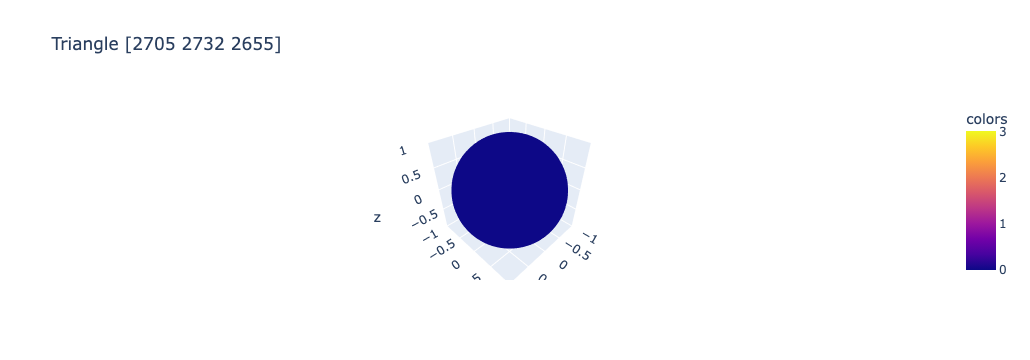

In [ ]:
triangles = create_triangles_from_pointcloud(X_sphere, D_euc_sphere, min_dist = 0.7, max_dist=1, num_triangles=14)
plot_triangle_in_3d(X_sphere, triangles[0], sphere.geodesics)

In [ ]:
ks, centroids = compute_triangle_curvatures(X_sphere, D_euc_sphere, sphere.geodesics, num_triangles = 100, min_edge_length = 0.7, max_edge_length = 1) # pretuned edge lengths

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_237264/792130572.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_237264/792130572.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
ks

array([ 0.02516624,  0.03490994,  0.01548076,  0.04635491,  0.03604354,
        0.03363762,  0.0301693 ,  0.02287817,  0.01740997,  0.03896149,
       -0.0035394 ,  0.03439819,  0.01501008,  0.02566044,  0.00443364,
        0.03939346,  0.02123658,  0.02459487,  0.03283364,  0.02883482,
        0.0121643 ,  0.03322837,  0.03368573,  0.0143388 ,  0.03922421,
        0.01972489,  0.01238543,  0.02247496,  0.01744166,  0.00674675,
        0.02316952,  0.03269682,  0.04452875,  0.03177351,  0.0315607 ,
        0.03577043,  0.03042181,  0.02881355,  0.02281306, -0.00193298,
        0.06144132,  0.02345738,  0.03192342,  0.01362161,  0.00705602,
        0.03028868,  0.02370873,  0.03037309,  0.02969606,  0.01942107,
        0.01378023,  0.01656863,  0.02414746,  0.01285545,  0.01153084,
        0.02332216,  0.02398545,  0.01089054,  0.02753693,  0.0258811 ,
        0.0287899 ,  0.0453993 ,  0.02347225,  0.02116526,  0.02889601,
        0.03776692,  0.02868356,  0.00640359,  0.02770414,  0.03

In [ ]:
get_ground_truth_curvature_at_triangle_centroids(X_sphere, sphere.ks, centroids)

tensor([2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 1.9982, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000])

In [ ]:
k, gs, c1_geodesic, d_geodesic = alexandrov_curvature_of_triangle(X_sphere, triangles[0], sphere.geodesics, return_extras = True)

/tmp/ipykernel_210617/792130572.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_210617/792130572.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
plot_3d_with_geodesics(X_sphere, gs, torch.vstack([c1_geodesic, d_geodesic]))

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                                 